In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
# Python packages
PythonTools_DIR = 'J:\\Projects\\JHUTrabeculae\\Software\\Python\\PythonTools'
pyimagej_DIR = 'J:\\Projects\\JHUTrabeculae\\Software\\Python\\pyimagej'
TrabeculaeTools_DIR = 'J:\\Projects\\JHUTrabeculae\\Software\\Python\\TrabeculaeTools'
elastix_DIR = 'J:\\Projects\\JHUTrabeculae\\Software\\Programs\\elastix'
ImageJ_DIR = 'J:\\Projects\\JHUTrabeculae\\Software\\Programs\\Fiji.app'
Macros_DIR = 'J:\\Projects\\JHUTrabeculae\\Software\\Python\\TrabeculaeTools\\BoneJMacros'

# Elastix registration
elastix_EXE = os.path.join(elastix_DIR,'elastix.exe')

# Path to imageJ (Need BoneJ and NII reader plugins)
ImageJ_EXE = os.path.join(ImageJ_DIR,'ImageJ-win64.exe')

# Macro definition for segmentation Trabeculae
SegmentfileDescription_XML = os.path.join(Macros_DIR,'SegmentTrabeculaImageJMacro.xml')
Segmentmacro_IJM = os.path.join(Macros_DIR,'SegmentTrabeculaImageJMacro.ijm')

# Macro definition for Metric Trabeculae
MetricfileDescription_XML= os.path.join(Macros_DIR,'BoneJMetricsImageJMacro.xml')
Metricmacro_IJM = os.path.join(Macros_DIR,'BoneJMetricsImageJMacro.ijm')

In [3]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import SimpleITK as sitk
from scipy.spatial.distance import dice, jaccard, matching, rogerstanimoto, russellrao, sokalmichener, sokalsneath, yule

# Add Python Tools to path
sys.path.append(PythonTools_DIR)

# Add pyimagej
sys.path.append(pyimagej_DIR)

# Add TrabeculaeTools
sys.path.append(TrabeculaeTools_DIR)

In [4]:
# PythonTools imports
from PythonTools.helpers.elastix import elastix as elastixhelper
from PythonTools import io, transformations

# pyimagej imports
from pyimagej.pyimagej import ImageJ, MacroImageJ

# TrabeculaeTools imports
from TrabeculaeTools.analysis import DownsampleImage, CreateRoIfileStudy, CreateRoI, CreateRoITransformed, PrintPercentage, ResampleImage
from TrabeculaeTools.analysis import SegmentTrabeculaeBoneJ, GetResultsFromSegmentation, GetResultsForComparison, LocalThresholding

In [25]:
CBCTimagePath = 'J:/Projects/JHUTrabeculae/Results/LocalThresholding/ParameterStudy/CBCT_roi.nii' 
uCTimagePath = 'J:/Projects/JHUTrabeculae/Results/LocalThresholding/ParameterStudy/uCT_roi.nii' 
uCTimagePath_segmentation = 'J:/Projects/JHUTrabeculae/Results/LocalThresholding/ParameterStudy/uCT_roi_segmentedBoneJ.nii' 

uCTResampledimagePath = 'J:/Projects/JHUTrabeculae/Results/LocalThresholding/ParameterStudy/uCT_roi_resampled.nii' 
uCTResampledimagePath_segmentation = 'J:/Projects/JHUTrabeculae/Results/LocalThresholding/ParameterStudy/uCT_roi_resampled_segmentedBoneJ.nii'

dataFile = 'J:/Projects/JHUTrabeculae/Results/LocalThresholding/ParameterStudy/ResultsAllMetrics.csv'

In [14]:
## Create uCT image with CBCT voxel size
uCTimageCBCTVoxelSize = ResampleImage(CBCTimagePath,uCTimagePath)
sitk.WriteImage(uCTimageCBCTVoxelSize,uCTResampledimagePath)

In [ ]:
## Create segmentations from uCT images

uCTdataSegmentation = SegmentTrabeculaeBoneJ(   ImageJ_EXE, Segmentmacro_IJM, SegmentfileDescription_XML, 
                                                    defaultTimeout = 700,\
                                                    PathToRoIfile = uCTimagePath,\
                                                    PathToSegmentedRoIfile = uCTimagePath_segmentation,\
                                                    SMOOTH_Sigma = 0.03,\
                                                    TH_Erosion = 0,\
                                                    TH_Dilation = 0)

In [26]:
uCTResampleddataSegmentation = SegmentTrabeculaeBoneJ(   ImageJ_EXE, Segmentmacro_IJM, SegmentfileDescription_XML, 
                                                    defaultTimeout = 700,\
                                                    PathToRoIfile = uCTResampledimagePath,\
                                                    PathToSegmentedRoIfile = uCTResampledimagePath_segmentation,\
                                                    SMOOTH_Sigma = 0.03,\
                                                    TH_Erosion = 0,\
                                                    TH_Dilation = 0)

In [ ]:
## Define the parameter study
######################
N = 10
GaussRadiusVector = np.linspace(0.05,1.5,N) # from 0.4 for low noise, and 1.0 for high noise
GradCutOffLowVector = np.linspace(0.05,0.9,N) # Decreasing result in inclusion of thinner trabeculae and noise. 
#GradCutOffHighVector = np.linspace(0.05,1.5,N)
BackGroundValueVector = np.linspace(-0.2,0.2,N) * 0.02  # Extracted from a RoI in the Non Trabeculae part using ImageJ
######################

In [32]:
# Calculate Jaccard and Dice between uCT and resampled uCT
gsimage = sitk.Cast(sitk.ReadImage(uCTimagePath_segmentation), sitk.sitkFloat32)
evimage = sitk.Cast(sitk.ReadImage(uCTResampledimagePath_segmentation), sitk.sitkFloat32)
evimage = sitk.Resample(evimage , gsimage,sitk.Transform(), sitk.sitkNearestNeighbor, sitk.sitkUInt8)

gsimage = sitk.GetArrayFromImage(gsimage)
evimage = sitk.GetArrayFromImage(evimage)

gsimage = gsimage.astype(bool)
evimage = evimage.astype(bool)

jaccardOriginaluCT = 1.0 - jaccard(gsimage.flatten(), evimage.flatten())
diceOriginaluCT = 1.0 - dice(gsimage.flatten(), evimage.flatten())
print jaccardOriginaluCT, diceOriginaluCT

0.650440121781 0.788202023445


In [52]:
# Create data structure

data = []

totalOperations = N**4
itpercentage = 0.0

for GaussRadius in GaussRadiusVector:
    for GradCutOffLow in GradCutOffLowVector:
        GradCutOffHighVector =  np.linspace(GradCutOffLow,0.99,N)
        for GradCutOffHigh in GradCutOffHighVector:
            for BackGroundValue in BackGroundValueVector:
                itpercentage = itpercentage + 1
                PrintPercentage(100.0*itpercentage/totalOperations)
                
                
                mask = LocalThresholding(CBCTimagePath, GaussRadius, GradCutOffLow, GradCutOffHigh, BackGroundValue)
                
                finalmask = CBCTimagePath[:-4] + "_{0:.5f}GR_{1:.5f}GCOL_{2:.5f}GCOH_{3:.5f}BGV.nii".format(GaussRadius,GradCutOffLow,GradCutOffHigh,BackGroundValue)
                sitk.WriteImage(mask,finalmask)
                
                
                # CALCULATE JACCARD AND DICE FOR uCT
                
                gsimage = sitk.Cast(sitk.ReadImage(uCTimagePath_segmentation), sitk.sitkFloat32)
                evimage = sitk.Cast(sitk.ReadImage(finalmask), sitk.sitkFloat32)
                evimage = sitk.Resample(evimage , gsimage,sitk.Transform(), sitk.sitkNearestNeighbor, sitk.sitkUInt8)

                gsimage = sitk.GetArrayFromImage(gsimage)
                evimage = sitk.GetArrayFromImage(evimage)
                
                gsimage = gsimage.astype(bool)
                evimage = evimage.astype(bool)
                
                jaccardOriginaluCT = 1.0 - jaccard(gsimage.flatten(), evimage.flatten())
                diceOriginaluCT = 1.0 - dice(gsimage.flatten(), evimage.flatten())
                
                matchingOriginaluCT = matching(gsimage.flatten(), evimage.flatten())
                rogerstanimotoOriginaluCT = rogerstanimoto(gsimage.flatten(), evimage.flatten())
                russellraoOriginaluCT = russellrao(gsimage.flatten(), evimage.flatten())
                sokalmichenerOriginaluCT = sokalmichener(gsimage.flatten(), evimage.flatten())
                sokalsneathOriginaluCT = sokalsneath(gsimage.flatten(), evimage.flatten())
                yuleOriginaluCT = yule(gsimage.flatten(), evimage.flatten())
                
                
                
                # CALCULATE JACCARD AND DICE FOR uCT Resampled
                
                gsimage = sitk.Cast(sitk.ReadImage(uCTResampledimagePath_segmentation), sitk.sitkFloat32)
                evimage = sitk.Cast(sitk.ReadImage(finalmask), sitk.sitkFloat32)
                evimage = sitk.Resample(evimage , gsimage,sitk.Transform(), sitk.sitkNearestNeighbor, sitk.sitkUInt8)

                gsimage = sitk.GetArrayFromImage(gsimage)
                evimage = sitk.GetArrayFromImage(evimage)
                
                gsimage = gsimage.astype(bool)
                evimage = evimage.astype(bool)
                
                jaccardResampleduCT = 1.0 - jaccard(gsimage.flatten(), evimage.flatten())
                diceResampleduCT = 1.0 - dice(gsimage.flatten(), evimage.flatten())
                matchingResampleduCT = matching(gsimage.flatten(), evimage.flatten())
                rogerstanimotoResampleduCT = rogerstanimoto(gsimage.flatten(), evimage.flatten())
                russellraoResampleduCT = russellrao(gsimage.flatten(), evimage.flatten())
                sokalmichenerResampleduCT = sokalmichener(gsimage.flatten(), evimage.flatten())
                sokalsneathResampleduCT = sokalsneath(gsimage.flatten(), evimage.flatten())
                yuleResampleduCT = yule(gsimage.flatten(), evimage.flatten())
                
                
                data.append({'GaussRadius':GaussRadius,\
                             'GradCutOffLow':GradCutOffLow,\
                             'GradCutOffHigh':GradCutOffHigh,\
                             'BackGroundValue':BackGroundValue,\
                             'Image':CBCTimagePath,\
                             'Segmented Image':finalmask,\
                             'Jaccard Original uCT':jaccardOriginaluCT,\
                             'Jaccard Resampled uCT':jaccardResampleduCT,\
                             'Dice Original uCT':diceOriginaluCT,\
                             'Dice Resampled uCT':diceResampleduCT,\
                             'Matching Original uCT':matchingOriginaluCT,\
                             'Rogerstanimoto Original uCT':rogerstanimotoOriginaluCT,\
                             'RusselRao Original uCT':russellraoOriginaluCT,\
                             'Sokalmichener Original uCT':sokalmichenerOriginaluCT,\
                             'Soikalsneath Original uCT':sokalsneathOriginaluCT,\
                             'Yule Original uCT':yuleOriginaluCT,\
                             'Matching Resampled uCT':matchingResampleduCT,\
                             'Rogerstanimoto Resampled uCT':rogerstanimotoResampleduCT,\
                             'RusselRao Resampled uCT':russellraoResampleduCT,\
                             'Sokalmichener Resampled uCT':sokalmichenerResampleduCT,\
                             'Soikalsneath Resampled uCT':sokalsneathResampleduCT,\
                             'Yule Resampled uCT':yuleResampleduCT\
                            })
                



myData = pd.DataFrame(data)
myData.to_csv(dataFile)

0.05 0.05
0.05 0.05
0.05 0.05
0.05 0.05
0.05 0.05
0.05 0.05
0.05 0.05
0.05 0.05
0.05 0.05
0.05 0.05
0.05 0.154444444444
0.05 0.154444444444
0.05 0.154444444444
0.05 0.154444444444
0.05 0.154444444444
0.05 0.154444444444
0.05 0.154444444444
0.05 0.154444444444
0.05 0.154444444444
0.05 0.154444444444
0.05 0.258888888889
0.05 0.258888888889
0.05 0.258888888889
0.05 0.258888888889
0.05 0.258888888889
0.05 0.258888888889
0.05 0.258888888889
0.05 0.258888888889
0.05 0.258888888889
0.05 0.258888888889
0.05 0.363333333333
0.05 0.363333333333
0.05 0.363333333333
0.05 0.363333333333
0.05 0.363333333333
0.05 0.363333333333
0.05 0.363333333333
0.05 0.363333333333
0.05 0.363333333333
0.05 0.363333333333
0.05 0.467777777778
0.05 0.467777777778
0.05 0.467777777778
0.05 0.467777777778
0.05 0.467777777778
0.05 0.467777777778
0.05 0.467777777778
0.05 0.467777777778
0.05 0.467777777778
0.05 0.467777777778
0.05 0.572222222222
0.05 0.572222222222
0.05 0.572222222222
0.05 0.572222222222
0.05 0.572222222222


In [102]:
# Create data structure

data = []

totalOperations = N**4
itpercentage = 0.0

for GaussRadius in GaussRadiusVector:
    for GradCutOffLow in GradCutOffLowVector:
        GradCutOffHighVector =  np.linspace(GradCutOffLow,0.99,N)
        for GradCutOffHigh in GradCutOffHighVector:
            for BackGroundValue in BackGroundValueVector:
                itpercentage = itpercentage + 1
                PrintPercentage(100.0*itpercentage/(totalOperations*1.0))
                finalmask = CBCTimagePath[:-4] + "_{0:.5f}GR_{1:.5f}GCOL_{2:.5f}GCOH_{3:.5f}BGV.nii".format(GaussRadius,GradCutOffLow,GradCutOffHigh,BackGroundValue)
                mask = sitk.Cast(sitk.ReadImage(finalmask), sitk.sitkFloat32)
                mask = sitk.Cast(mask,sitk.sitkUInt8)

                
                # CALCULATE JACCARD AND DICE FOR uCT
                
                gsimage = sitk.Cast(sitk.ReadImage(uCTimagePath_segmentation), sitk.sitkUInt8)
                evimage = sitk.Resample(mask , gsimage,sitk.Transform(), sitk.sitkNearestNeighbor, sitk.sitkUInt8)

                gsimage = sitk.GetArrayFromImage(gsimage)
                evimage = sitk.GetArrayFromImage(evimage)
                
                gsimage = gsimage.astype(bool)
                evimage = evimage.astype(bool)
                
                jaccardOriginaluCT = 1.0 - jaccard(gsimage.flatten(), evimage.flatten())
                diceOriginaluCT = 1.0 - dice(gsimage.flatten(), evimage.flatten())
                matchingOriginaluCT = matching(gsimage.flatten(), evimage.flatten())
                rogerstanimotoOriginaluCT = rogerstanimoto(gsimage.flatten(), evimage.flatten())
                russellraoOriginaluCT = russellrao(gsimage.flatten(), evimage.flatten())
                sokalmichenerOriginaluCT = sokalmichener(gsimage.flatten(), evimage.flatten())
                sokalsneathOriginaluCT = sokalsneath(gsimage.flatten(), evimage.flatten())
                yuleOriginaluCT = yule(gsimage.flatten(), evimage.flatten())
                
                # CALCULATE JACCARD AND DICE FOR uCT Resampled
                
                gsimage = sitk.Cast(sitk.ReadImage(uCTResampledimagePath_segmentation), sitk.sitkUInt8)

                gsimage = sitk.GetArrayFromImage(gsimage)
                evimage = sitk.GetArrayFromImage(mask)
                
                gsimage = gsimage.astype(bool)
                evimage = evimage.astype(bool)
                
                jaccardResampleduCT = 1.0 - jaccard(gsimage.flatten(), evimage.flatten())
                diceResampleduCT = 1.0 - dice(gsimage.flatten(), evimage.flatten())
                jaccardResampleduCT = 1.0 - jaccard(gsimage.flatten(), evimage.flatten())
                diceResampleduCT = 1.0 - dice(gsimage.flatten(), evimage.flatten())
                matchingResampleduCT = matching(gsimage.flatten(), evimage.flatten())
                rogerstanimotoResampleduCT = rogerstanimoto(gsimage.flatten(), evimage.flatten())
                russellraoResampleduCT = russellrao(gsimage.flatten(), evimage.flatten())
                sokalmichenerResampleduCT = sokalmichener(gsimage.flatten(), evimage.flatten())
                sokalsneathResampleduCT = sokalsneath(gsimage.flatten(), evimage.flatten())
                yuleResampleduCT = yule(gsimage.flatten(), evimage.flatten())
                
                
                data.append({'GaussRadius':GaussRadius,\
                             'GradCutOffLow':GradCutOffLow,\
                             'GradCutOffHigh':GradCutOffHigh,\
                             'BackGroundValue':BackGroundValue,\
                             'Image':CBCTimagePath,\
                             'Segmented Image':finalmask,\
                             'Jaccard Original uCT':jaccardOriginaluCT,\
                             'Jaccard Resampled uCT':jaccardResampleduCT,\
                             'Dice Original uCT':diceOriginaluCT,\
                             'Dice Resampled uCT':diceResampleduCT,\
                             'Matching Original uCT':matchingOriginaluCT,\
                             'Rogerstanimoto Original uCT':rogerstanimotoOriginaluCT,\
                             'RusselRao Original uCT':russellraoOriginaluCT,\
                             'Sokalmichener Original uCT':sokalmichenerOriginaluCT,\
                             'Soikalsneath Original uCT':sokalsneathOriginaluCT,\
                             'Yule Original uCT':yuleOriginaluCT,\
                             'Matching Resampled uCT':matchingResampleduCT,\
                             'Rogerstanimoto Resampled uCT':rogerstanimotoResampleduCT,\
                             'RusselRao Resampled uCT':russellraoResampleduCT,\
                             'Sokalmichener Resampled uCT':sokalmichenerResampleduCT,\
                             'Soikalsneath Resampled uCT':sokalsneathResampleduCT,\
                             'Yule Resampled uCT':yuleResampleduCT\
                            })
                
                



myData = pd.DataFrame(data)
myData.to_csv(dataFile)                
                
                
                
                
   

[100.00%]--[||||||||||||||||||||]-- Expected end in [0:00:00] Finished!

Float64Index([0.211111111111], dtype='float64', name=u'GaussRadius')


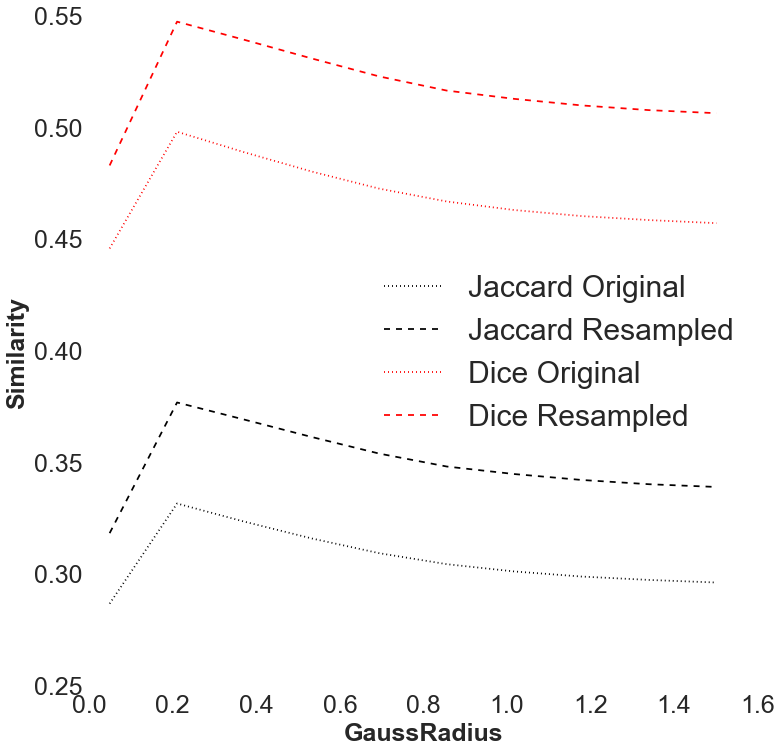

In [129]:
dfmedian = myData.groupby(['GaussRadius']).median()
x = dfmedian.index

jaccardOriginal = dfmedian['Jaccard Original uCT'].values
jaccardResampled = dfmedian['Jaccard Resampled uCT'].values
diceOriginal = dfmedian['Dice Original uCT'].values
diceResampled = dfmedian['Dice Resampled uCT'].values

##########################################################################
plotsize = 12
sizeFont = 25
f, ax = plt.subplots(1,figsize=(plotsize,plotsize),facecolor='white')
ax.tick_params(axis='x', labelsize = sizeFont)
ax.tick_params(axis='y', labelsize = sizeFont)

h1, = ax.plot(x,jaccardOriginal, 'k:')
h2, = ax.plot(x,jaccardResampled, 'k--')
h3, = ax.plot(x,diceOriginal, 'r:')
h4, = ax.plot(x,diceResampled, 'r--')

ax.legend([h1,h2,h3,h4], ['Jaccard Original', 'Jaccard Resampled', 'Dice Original', 'Dice Resampled'], loc='best',prop={'size':30})

ax.set_axis_bgcolor('white')
ax.set_title('\n', fontsize=sizeFont, fontweight='bold')
ax.set_xlabel('GaussRadius', fontsize=sizeFont, fontweight='bold')
ax.set_ylabel('Similarity', fontsize=sizeFont, fontweight='bold')

optimalGaussRadius =  x[np.where(diceResampled == diceResampled.max())[0]]

print optimalGaussRadius

Float64Index([0.9], dtype='float64', name=u'GradCutOffLow')


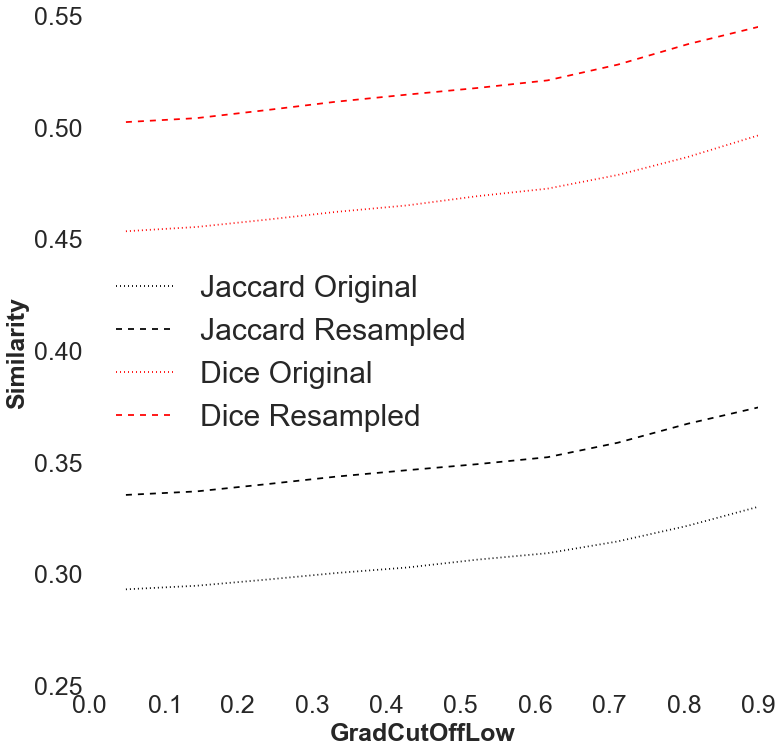

In [130]:
dfmedian = myData.groupby(['GradCutOffLow']).median()
x = dfmedian.index

jaccardOriginal = dfmedian['Jaccard Original uCT'].values
jaccardResampled = dfmedian['Jaccard Resampled uCT'].values
diceOriginal = dfmedian['Dice Original uCT'].values
diceResampled = dfmedian['Dice Resampled uCT'].values

##########################################################################
plotsize = 12
sizeFont = 25
f, ax = plt.subplots(1,figsize=(plotsize,plotsize),facecolor='white')
ax.tick_params(axis='x', labelsize = sizeFont)
ax.tick_params(axis='y', labelsize = sizeFont)

h1, = ax.plot(x,jaccardOriginal, 'k:')
h2, = ax.plot(x,jaccardResampled, 'k--')
h3, = ax.plot(x,diceOriginal, 'r:')
h4, = ax.plot(x,diceResampled, 'r--')

ax.legend([h1,h2,h3,h4], ['Jaccard Original', 'Jaccard Resampled', 'Dice Original', 'Dice Resampled'], loc='best',prop={'size':30})

ax.set_axis_bgcolor('white')
ax.set_title('\n', fontsize=sizeFont, fontweight='bold')
ax.set_xlabel('GradCutOffLow', fontsize=sizeFont, fontweight='bold')
ax.set_ylabel('Similarity', fontsize=sizeFont, fontweight='bold')

optimalGradCutOffLow =  x[np.where(diceResampled == diceResampled.max())[0]]

print optimalGradCutOffLow


Float64Index([0.98], dtype='float64', name=u'GradCutOffHigh')


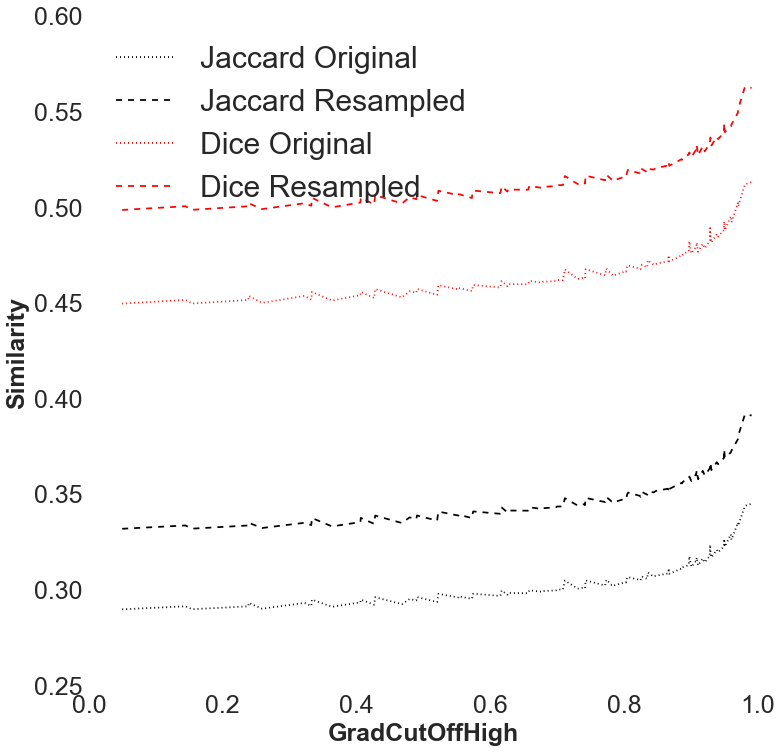

In [131]:
dfmedian = myData.groupby(['GradCutOffHigh']).median()
x = dfmedian.index

jaccardOriginal = dfmedian['Jaccard Original uCT'].values
jaccardResampled = dfmedian['Jaccard Resampled uCT'].values
diceOriginal = dfmedian['Dice Original uCT'].values
diceResampled = dfmedian['Dice Resampled uCT'].values

##########################################################################
plotsize = 12
sizeFont = 25
f, ax = plt.subplots(1,figsize=(plotsize,plotsize),facecolor='white')
ax.tick_params(axis='x', labelsize = sizeFont)
ax.tick_params(axis='y', labelsize = sizeFont)

h1, = ax.plot(x,jaccardOriginal, 'k:')
h2, = ax.plot(x,jaccardResampled, 'k--')
h3, = ax.plot(x,diceOriginal, 'r:')
h4, = ax.plot(x,diceResampled, 'r--')

ax.legend([h1,h2,h3,h4], ['Jaccard Original', 'Jaccard Resampled', 'Dice Original', 'Dice Resampled'], loc='best',prop={'size':30})

ax.set_axis_bgcolor('white')
ax.set_title('\n', fontsize=sizeFont, fontweight='bold')
ax.set_xlabel('GradCutOffHigh', fontsize=sizeFont, fontweight='bold')
ax.set_ylabel('Similarity', fontsize=sizeFont, fontweight='bold')

optimalGradCutOffHigh =  x[np.where(diceResampled == diceResampled.max())[0]]

print optimalGradCutOffHigh


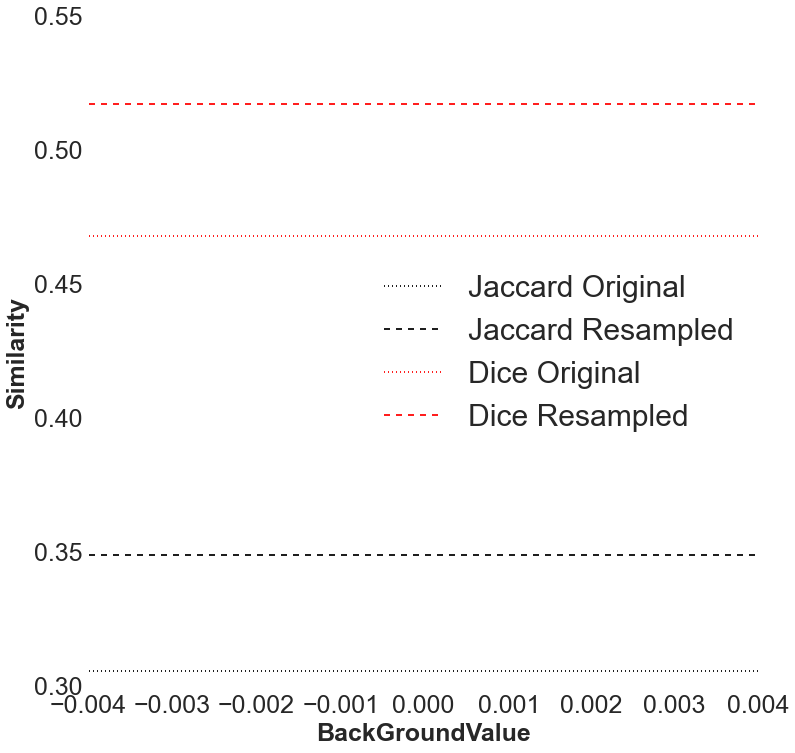

In [112]:

dfmedian = myData.groupby(['BackGroundValue']).median()
x = dfmedian.index

jaccardOriginal = dfmedian['Jaccard Original uCT'].values
jaccardResampled = dfmedian['Jaccard Resampled uCT'].values
diceOriginal = dfmedian['Dice Original uCT'].values
diceResampled = dfmedian['Dice Resampled uCT'].values

##########################################################################
plotsize = 12
sizeFont = 25
f, ax = plt.subplots(1,figsize=(plotsize,plotsize),facecolor='white')
ax.tick_params(axis='x', labelsize = sizeFont)
ax.tick_params(axis='y', labelsize = sizeFont)

h1, = ax.plot(x,jaccardOriginal, 'k:')
h2, = ax.plot(x,jaccardResampled, 'k--')
h3, = ax.plot(x,diceOriginal, 'r:')
h4, = ax.plot(x,diceResampled, 'r--')

ax.legend([h1,h2,h3,h4], ['Jaccard Original', 'Jaccard Resampled', 'Dice Original', 'Dice Resampled'], loc='best',prop={'size':30})

ax.set_axis_bgcolor('white')
ax.set_title('\n', fontsize=sizeFont, fontweight='bold')
ax.set_xlabel('BackGroundValue', fontsize=sizeFont, fontweight='bold')
ax.set_ylabel('Similarity', fontsize=sizeFont, fontweight='bold')

In [8]:
## Define the parameter study
######################
N = 10
GaussRadiusVector = [0.21]# from 0.4 for low noise, and 1.0 for high noise
GradCutOffLowVector = np.linspace(0.9,0.998,N) # Decreasing result in inclusion of thinner trabeculae and noise. 
BackGroundValueVector = [0.02]  # Extracted from a RoI in the Non Trabeculae part using ImageJ
######################
dataFile = uCTResampledimagePath = 'J:/Projects/JHUTrabeculae/Results/LocalThresholding/ParameterStudy/ResultsAllMetricFocus.csv'

data = []

totalOperations = N**2.0
itpercentage = 0.0

__previousPercentage = 0.0

for GaussRadius in GaussRadiusVector:
    for GradCutOffLow in GradCutOffLowVector:
        GradCutOffHighVector =  np.linspace(GradCutOffLow,0.999,N)
        for GradCutOffHigh in GradCutOffHighVector:
            for BackGroundValue in BackGroundValueVector:
                itpercentage = itpercentage + 1
                PrintPercentage(100.0*itpercentage/(1.0*totalOperations))
                
                
                mask = LocalThresholding(CBCTimagePath, GaussRadius, GradCutOffLow, GradCutOffHigh, BackGroundValue)
                
                finalmask = CBCTimagePath[:-4] + "_{0:.5f}GR_{1:.5f}GCOL_{2:.5f}GCOH_{3:.5f}BGV.nii".format(GaussRadius,GradCutOffLow,GradCutOffHigh,BackGroundValue)
                sitk.WriteImage(mask,finalmask)
                
                
                # CALCULATE JACCARD AND DICE FOR uCT
                
                gsimage = sitk.Cast(sitk.ReadImage(uCTimagePath_segmentation), sitk.sitkFloat32)
                evimage = sitk.Cast(sitk.ReadImage(finalmask), sitk.sitkFloat32)
                evimage = sitk.Resample(evimage , gsimage,sitk.Transform(), sitk.sitkNearestNeighbor, sitk.sitkUInt8)

                gsimage = sitk.GetArrayFromImage(gsimage)
                evimage = sitk.GetArrayFromImage(evimage)
                
                gsimage = gsimage.astype(bool)
                evimage = evimage.astype(bool)
                
                jaccardOriginaluCT = 1.0 - jaccard(gsimage.flatten(), evimage.flatten())
                diceOriginaluCT = 1.0 - dice(gsimage.flatten(), evimage.flatten())
                
                matchingOriginaluCT = matching(gsimage.flatten(), evimage.flatten())
                rogerstanimotoOriginaluCT = rogerstanimoto(gsimage.flatten(), evimage.flatten())
                russellraoOriginaluCT = russellrao(gsimage.flatten(), evimage.flatten())
                sokalmichenerOriginaluCT = sokalmichener(gsimage.flatten(), evimage.flatten())
                sokalsneathOriginaluCT = sokalsneath(gsimage.flatten(), evimage.flatten())
                yuleOriginaluCT = yule(gsimage.flatten(), evimage.flatten())
                
                
                
                # CALCULATE JACCARD AND DICE FOR uCT Resampled
                
                gsimage = sitk.Cast(sitk.ReadImage(uCTResampledimagePath_segmentation), sitk.sitkFloat32)
                evimage = sitk.Cast(sitk.ReadImage(finalmask), sitk.sitkFloat32)
                evimage = sitk.Resample(evimage , gsimage,sitk.Transform(), sitk.sitkNearestNeighbor, sitk.sitkUInt8)

                gsimage = sitk.GetArrayFromImage(gsimage)
                evimage = sitk.GetArrayFromImage(evimage)
                
                gsimage = gsimage.astype(bool)
                evimage = evimage.astype(bool)
                
                jaccardResampleduCT = 1.0 - jaccard(gsimage.flatten(), evimage.flatten())
                diceResampleduCT = 1.0 - dice(gsimage.flatten(), evimage.flatten())
                matchingResampleduCT = matching(gsimage.flatten(), evimage.flatten())
                rogerstanimotoResampleduCT = rogerstanimoto(gsimage.flatten(), evimage.flatten())
                russellraoResampleduCT = russellrao(gsimage.flatten(), evimage.flatten())
                sokalmichenerResampleduCT = sokalmichener(gsimage.flatten(), evimage.flatten())
                sokalsneathResampleduCT = sokalsneath(gsimage.flatten(), evimage.flatten())
                yuleResampleduCT = yule(gsimage.flatten(), evimage.flatten())
                
                
                data.append({'GaussRadius':GaussRadius,\
                             'GradCutOffLow':GradCutOffLow,\
                             'GradCutOffHigh':GradCutOffHigh,\
                             'BackGroundValue':BackGroundValue,\
                             'Image':CBCTimagePath,\
                             'Segmented Image':finalmask,\
                             'Jaccard Original uCT':jaccardOriginaluCT,\
                             'Jaccard Resampled uCT':jaccardResampleduCT,\
                             'Dice Original uCT':diceOriginaluCT,\
                             'Dice Resampled uCT':diceResampleduCT,\
                             'Matching Original uCT':matchingOriginaluCT,\
                             'Rogerstanimoto Original uCT':rogerstanimotoOriginaluCT,\
                             'RusselRao Original uCT':russellraoOriginaluCT,\
                             'Sokalmichener Original uCT':sokalmichenerOriginaluCT,\
                             'Soikalsneath Original uCT':sokalsneathOriginaluCT,\
                             'Yule Original uCT':yuleOriginaluCT,\
                             'Matching Resampled uCT':matchingResampleduCT,\
                             'Rogerstanimoto Resampled uCT':rogerstanimotoResampleduCT,\
                             'RusselRao Resampled uCT':russellraoResampleduCT,\
                             'Sokalmichener Resampled uCT':sokalmichenerResampleduCT,\
                             'Soikalsneath Resampled uCT':sokalsneathResampleduCT,\
                             'Yule Resampled uCT':yuleResampleduCT\
                            })
                



myData2 = pd.DataFrame(data)
myData2.to_csv(dataFile)



[100.00%]--[||||||||||||||||||||]-- Expected end in [0:00:00] Finished!

0.965333333333


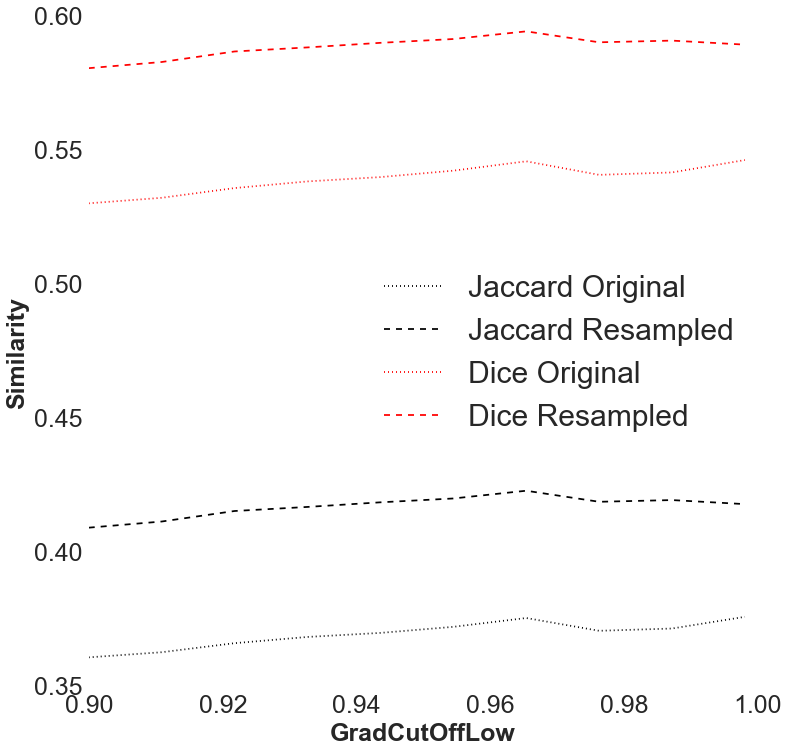

In [18]:
dfmedian = myData2.groupby(['GradCutOffLow']).median()
x = dfmedian.index

jaccardOriginal = dfmedian['Jaccard Original uCT'].values
jaccardResampled = dfmedian['Jaccard Resampled uCT'].values
diceOriginal = dfmedian['Dice Original uCT'].values
diceResampled = dfmedian['Dice Resampled uCT'].values

##########################################################################
plotsize = 12
sizeFont = 25
f, ax = plt.subplots(1,figsize=(plotsize,plotsize),facecolor='white')
ax.tick_params(axis='x', labelsize = sizeFont)
ax.tick_params(axis='y', labelsize = sizeFont)

h1, = ax.plot(x,jaccardOriginal, 'k:')
h2, = ax.plot(x,jaccardResampled, 'k--')
h3, = ax.plot(x,diceOriginal, 'r:')
h4, = ax.plot(x,diceResampled, 'r--')

ax.legend([h1,h2,h3,h4], ['Jaccard Original', 'Jaccard Resampled', 'Dice Original', 'Dice Resampled'], loc='best',prop={'size':30})

ax.set_axis_bgcolor('white')
ax.set_title('\n', fontsize=sizeFont, fontweight='bold')
ax.set_xlabel('GradCutOffLow', fontsize=sizeFont, fontweight='bold')
ax.set_ylabel('Similarity', fontsize=sizeFont, fontweight='bold')

optimalGradCutOffLow =  x[np.where(diceResampled == diceResampled.max())[0]]

print optimalGradCutOffLow.values[0]

Float64Index([0.998111111111], dtype='float64', name=u'GradCutOffHigh')


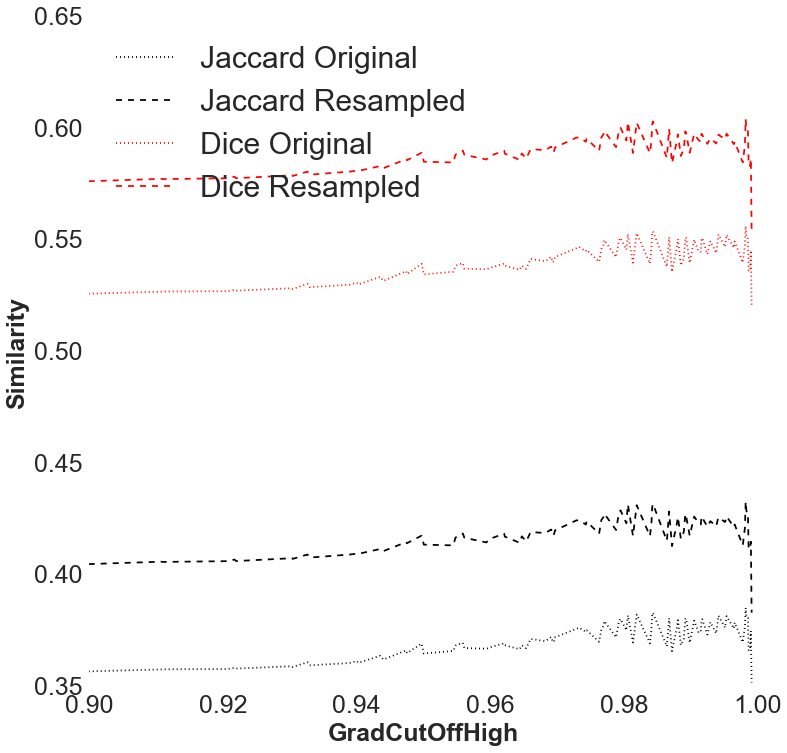

In [15]:
dfmedian = myData2.groupby(['GradCutOffHigh']).median()
x = dfmedian.index

jaccardOriginal = dfmedian['Jaccard Original uCT'].values
jaccardResampled = dfmedian['Jaccard Resampled uCT'].values
diceOriginal = dfmedian['Dice Original uCT'].values
diceResampled = dfmedian['Dice Resampled uCT'].values

##########################################################################
plotsize = 12
sizeFont = 25
f, ax = plt.subplots(1,figsize=(plotsize,plotsize),facecolor='white')
ax.tick_params(axis='x', labelsize = sizeFont)
ax.tick_params(axis='y', labelsize = sizeFont)

h1, = ax.plot(x,jaccardOriginal, 'k:')
h2, = ax.plot(x,jaccardResampled, 'k--')
h3, = ax.plot(x,diceOriginal, 'r:')
h4, = ax.plot(x,diceResampled, 'r--')

ax.legend([h1,h2,h3,h4], ['Jaccard Original', 'Jaccard Resampled', 'Dice Original', 'Dice Resampled'], loc='best',prop={'size':30})

ax.set_axis_bgcolor('white')
ax.set_title('\n', fontsize=sizeFont, fontweight='bold')
ax.set_xlabel('GradCutOffHigh', fontsize=sizeFont, fontweight='bold')
ax.set_ylabel('Similarity', fontsize=sizeFont, fontweight='bold')

optimalGradCutOffHigh =  x[np.where(diceResampled == diceResampled.max())[0]]

print optimalGradCutOffHigh

0.995259259259


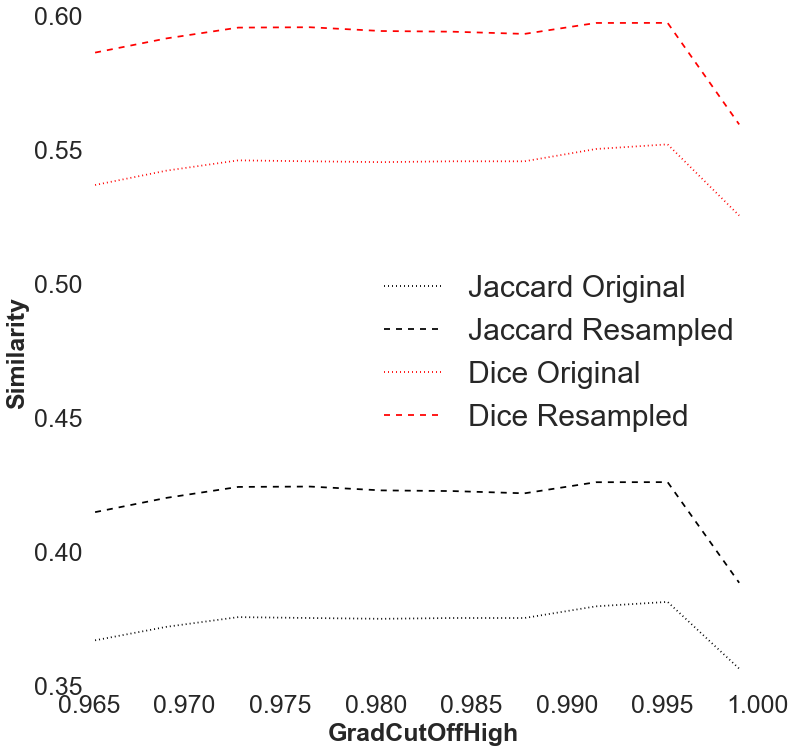

In [29]:
dfmedian = myData2[myData2['GradCutOffLow'] == optimalGradCutOffLow.values[0]]

dfmedian = dfmedian.groupby(['GradCutOffHigh']).median()
x = dfmedian.index

jaccardOriginal = dfmedian['Jaccard Original uCT'].values
jaccardResampled = dfmedian['Jaccard Resampled uCT'].values
diceOriginal = dfmedian['Dice Original uCT'].values
diceResampled = dfmedian['Dice Resampled uCT'].values

##########################################################################
plotsize = 12
sizeFont = 25
f, ax = plt.subplots(1,figsize=(plotsize,plotsize),facecolor='white')
ax.tick_params(axis='x', labelsize = sizeFont)
ax.tick_params(axis='y', labelsize = sizeFont)

h1, = ax.plot(x,jaccardOriginal, 'k:')
h2, = ax.plot(x,jaccardResampled, 'k--')
h3, = ax.plot(x,diceOriginal, 'r:')
h4, = ax.plot(x,diceResampled, 'r--')

ax.legend([h1,h2,h3,h4], ['Jaccard Original', 'Jaccard Resampled', 'Dice Original', 'Dice Resampled'], loc='best',prop={'size':30})

ax.set_axis_bgcolor('white')
ax.set_title('\n', fontsize=sizeFont, fontweight='bold')
ax.set_xlabel('GradCutOffHigh', fontsize=sizeFont, fontweight='bold')
ax.set_ylabel('Similarity', fontsize=sizeFont, fontweight='bold')

optimalGradCutOffHigh =  x[np.where(diceResampled == diceResampled.max())[0]]

print optimalGradCutOffHigh.values[0]

In [30]:
# Optimal Segmentation
GaussRadius = 0.21
GradCutOffLow = optimalGradCutOffLow.values[0]
GradCutOffHigh = optimalGradCutOffHigh.values[0]
BackGroundValue = 0.02

mask = LocalThresholding(CBCTimagePath, GaussRadius, GradCutOffLow, GradCutOffHigh, BackGroundValue)
finalmask = CBCTimagePath[:-4] + "_Optimal.nii".format(GaussRadius,GradCutOffLow,GradCutOffHigh,BackGroundValue)
sitk.WriteImage(mask,finalmask)

0.965333333333


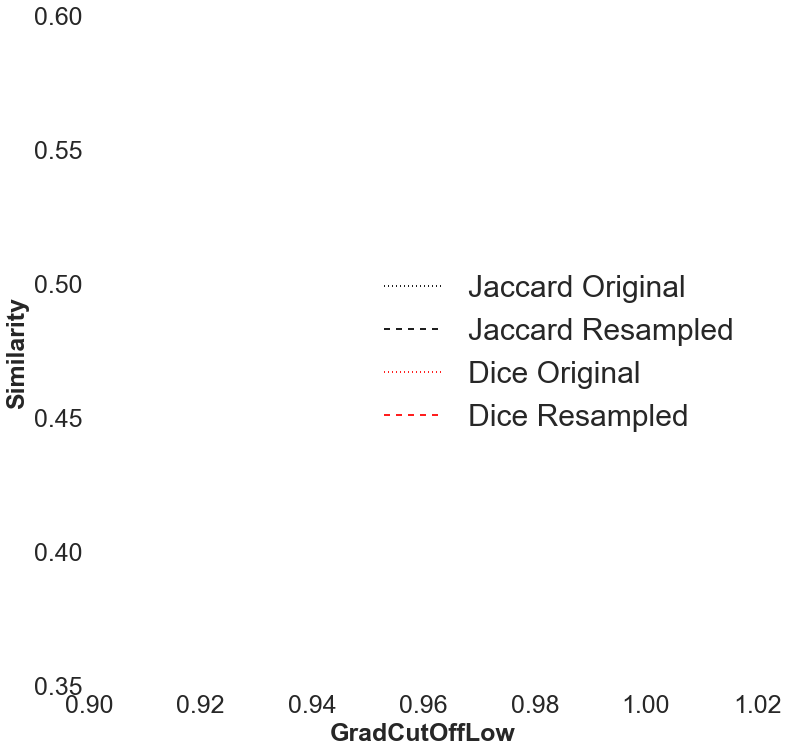

In [31]:
dfmedian = myData2[myData2['GradCutOffHigh'] == optimalGradCutOffHigh.values[0]]

dfmedian = dfmedian.groupby(['GradCutOffLow']).median()
x = dfmedian.index

jaccardOriginal = dfmedian['Jaccard Original uCT'].values
jaccardResampled = dfmedian['Jaccard Resampled uCT'].values
diceOriginal = dfmedian['Dice Original uCT'].values
diceResampled = dfmedian['Dice Resampled uCT'].values

##########################################################################
plotsize = 12
sizeFont = 25
f, ax = plt.subplots(1,figsize=(plotsize,plotsize),facecolor='white')
ax.tick_params(axis='x', labelsize = sizeFont)
ax.tick_params(axis='y', labelsize = sizeFont)

h1, = ax.plot(x,jaccardOriginal, 'k:')
h2, = ax.plot(x,jaccardResampled, 'k--')
h3, = ax.plot(x,diceOriginal, 'r:')
h4, = ax.plot(x,diceResampled, 'r--')

ax.legend([h1,h2,h3,h4], ['Jaccard Original', 'Jaccard Resampled', 'Dice Original', 'Dice Resampled'], loc='best',prop={'size':30})

ax.set_axis_bgcolor('white')
ax.set_title('\n', fontsize=sizeFont, fontweight='bold')
ax.set_xlabel('GradCutOffLow', fontsize=sizeFont, fontweight='bold')
ax.set_ylabel('Similarity', fontsize=sizeFont, fontweight='bold')

optimalGradCutOffHigh =  x[np.where(diceResampled == diceResampled.max())[0]]

print optimalGradCutOffHigh.values[0]